In [1]:
from src import soporte as sp

In [2]:
#Leemos los CSVs

df1 = sp.pd.read_csv('files/Customer Flight Activity.csv')
df2 = sp.pd.read_csv('files/Customer Loyalty History.csv')

### Después de explorar los csv, aplicamos los siguientes cambios:

DF1:

- Cambiar el tipo de dato de Points Accumulated a int
- Agrupar por número de cliente, año y mes, sumando el resto de columnas entre sí. 

DF2:

- Imputar nulos en la columna Salary, pasar a positivo y cambiar a tipo int.
- Cambiar el tipo de dato en Cancellation Year y Cancellation Month a tipo int.

In [3]:
#Agrupamos por "Loyalty Number", "Year" y "Month" y sumamos el resto de columnas.
df1 = df1.groupby(["Loyalty Number", "Year", "Month"], as_index=False).sum()

#Con esto eliminamos duplicados

Unimos los dataframes para aplicar las funciones correspondientes (el resultado no cambia si aplicamos antes o después de la unión)

In [4]:
#Unimos ambos dfs por la columna que mantienen en común: 'Loyalty Number'
df = sp.pd.merge(df1, df2, on='Loyalty Number')

Aplicamos los cambios restantes:

In [5]:
columnas_int = ['Points Accumulated', 'Cancellation Year', 'Cancellation Month']

# cambiamos tipo de datos a float
for columna in columnas_int:
    df[columna] = df[columna].apply(sp.cambiar_tipo_int)
print(f"Tipos de datos cambiados a int para las columnas: {columnas_int}")
print(f"Tipos de datos después del cambio: {df[columnas_int].dtypes}")
print("---" * 20)

Tipos de datos cambiados a int para las columnas: ['Points Accumulated', 'Cancellation Year', 'Cancellation Month']
Tipos de datos después del cambio: Points Accumulated    int64
Cancellation Year     int64
Cancellation Month    int64
dtype: object
------------------------------------------------------------


In [6]:
#Eliminamos valores negativos en 'Salary'
df['Salary'] = df['Salary'].apply(lambda x: -x if x < 0 else x)

Imputamos nulos en la columna 'Salary':

In [7]:
#Calculamos el porcentaje de nulos para saber si podemos imputar o no
df['Salary'].isnull().sum() / df.shape[0]*100

25.321144769074504

In [8]:
#Estudiamos la media y la mediana para ver qué valor nos interesa sustituir por los valores nulos:
df["Salary"].describe()[["mean", "50%", 'max', 'min']]

mean     79359.340907
50%      73455.000000
max     407228.000000
min       9081.000000
Name: Salary, dtype: float64

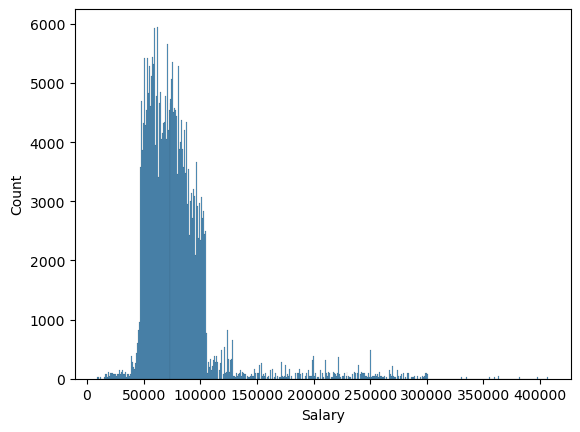

In [9]:
# Observamos la distribución de la columna

sp.sns.histplot(x = "Salary", data = df);

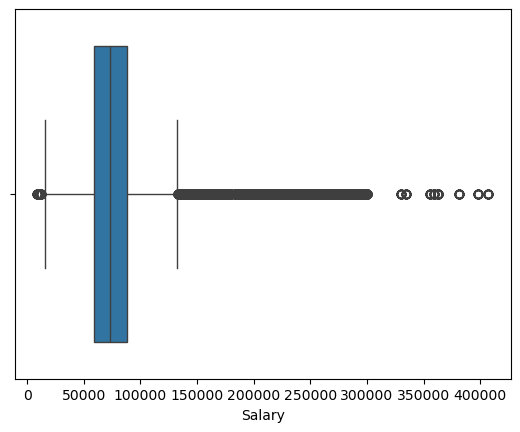

In [10]:
# Vemos los outliers:

sp.sns.boxplot(x= "Salary", data = df);

Como podemos ver, los datos están sesgados (la media es mayor que la mediana debido a los outliers), por eso, usaremos la mediana para imputar los valores nulos.

In [11]:
# creamos el objeto de la clase del SimpleImputer
imp_salary = sp.SimpleImputer(strategy = 'median')

# ajustamos y transformamos los datos
salary = imp_salary.fit_transform(df[["Salary"]])

# actualizamos la columna 'Salary' con los datos imputados
df["Salary"] = salary

# comprobamos si tenemos nulos. 
df['Salary'].isnull().sum()

0

In [12]:
#Transformamos los datos a integer
df['Salary'] = df['Salary'].apply(lambda x: int(x))

# Verificamos los tipos de datos del df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401688 entries, 0 to 401687
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Loyalty Number               401688 non-null  int64  
 1   Year                         401688 non-null  int64  
 2   Month                        401688 non-null  int64  
 3   Flights Booked               401688 non-null  int64  
 4   Flights with Companions      401688 non-null  int64  
 5   Total Flights                401688 non-null  int64  
 6   Distance                     401688 non-null  int64  
 7   Points Accumulated           401688 non-null  int64  
 8   Points Redeemed              401688 non-null  int64  
 9   Dollar Cost Points Redeemed  401688 non-null  int64  
 10  Country                      401688 non-null  object 
 11  Province                     401688 non-null  object 
 12  City                         401688 non-null  object 
 13 

Una vez están todos los datos limpios, guardamos el df en un nuevo csv:

In [13]:
df.to_csv('files/df_merged.csv')

---
Respondemos con visualizaciones:

1. ¿Cómo se distribuye la cantidad de vuelos reservados por mes durante el año?

In [14]:
#Guardamos un nuevo df con las columnas ["Year", 'Month', 'Total Flights'] para trabajar sobre ellas
df_flights = df[["Year", 'Month', 'Total Flights']]

# Agrupamos por columnas 'Year' y 'Month' y sumamos el número total de vuelos
df_flights = df_flights.groupby(["Year", 'Month'], as_index=False).sum()

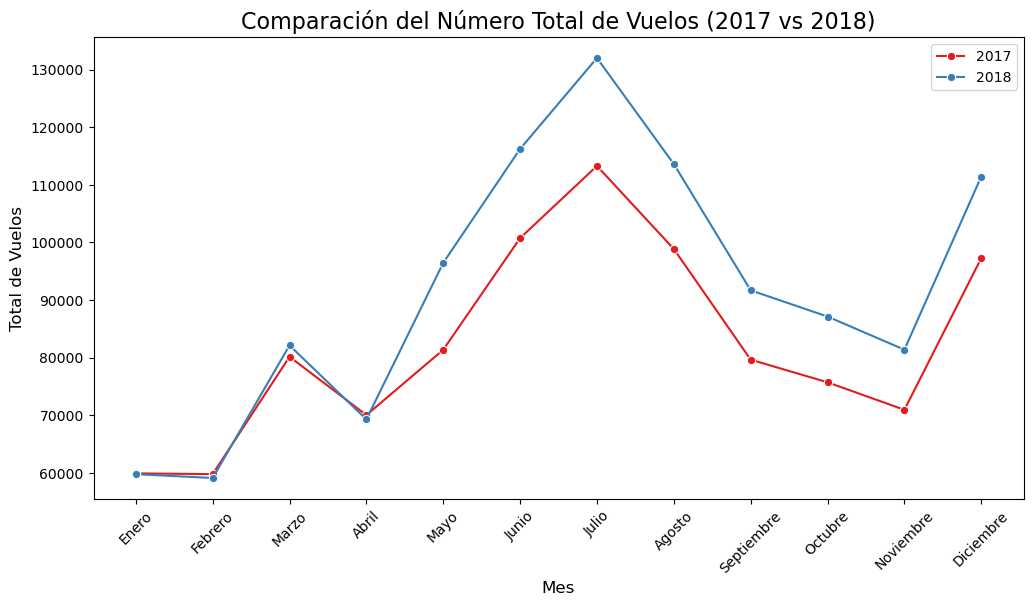

In [15]:
# Creamos el gráfico con Seaborn, diferenciando por año:
sp.plt.figure(figsize=(12, 6))
sp.sns.lineplot(data=df_flights, x="Month", y="Total Flights", hue="Year", marker="o", palette='Set1')

# Personalización
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
            'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
sp.plt.title('Comparación del Número Total de Vuelos (2017 vs 2018)', fontsize=16)
sp.plt.xlabel('Mes', fontsize=12)
sp.plt.ylabel('Total de Vuelos', fontsize=12)
sp.plt.xticks(ticks=range(1, 13), labels=meses, rotation=45, fontsize=10)
sp.plt.legend()
sp.plt.show()

2018 parece haber tenido un mayor número de vuelos reservados en verano (junio, julio y agosto), destacando en el pico de junio, mientras que 2017 mantuvo una distribución más equilibrada a lo largo del año. La caída en vuelos en los últimos meses de ambos años podría estar relacionada con la temporada baja, donde hay menos demanda.

---

2. ¿Existe una relación entre la distancia de los vuelos y los puntos acumulados por los cliente?

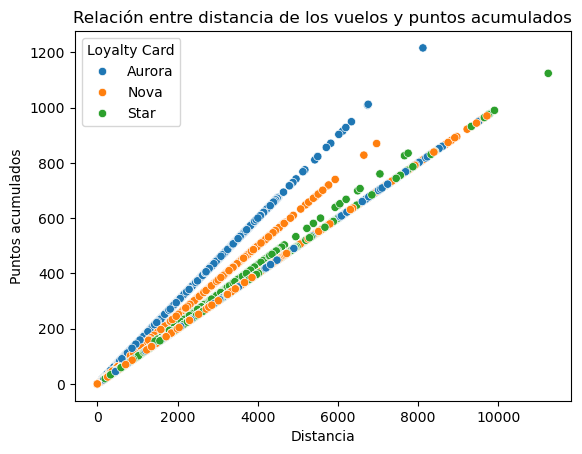

In [16]:
# creamos una gráfica básica usando 'sns.scatterplot()' y diferenciando entre los distintos programas de fidelización
sp.sns.scatterplot(x = "Distance", 
                y = "Points Accumulated", 
                data = df,
                hue= "Loyalty Card")

# cambiamos los nombres de los ejes
sp.plt.xlabel("Distancia")
sp.plt.ylabel("Puntos acumulados")
sp.plt.title('Relación entre distancia de los vuelos y puntos acumulados');

Hay una relación positiva: a mayor distancia, mayor número de puntos acumulados, esto sugiere que los puntos acumulados están probablemente determinados por la distancia recorrida, quizás como parte del sistema de fidelidad para los usuarios.

Las líneas formadas por los puntos de cada color indican que cada programa tiene una tasa diferente de acumulación de puntos.
- Aurora (Azul): Acumula puntos más rápidamente (mayor pendiente).
- Nova (Naranja): Tasa de acumulación intermedia.
- Star (Verde): Acumula puntos más lentamente (menor pendiente).

Es posible que el programa de fidelidad ofrezca un valor base uniforme (independiente del programa) para un número de viajes hasta alcanzar un mínimo, quizás para incentivar la participación de nuevos usuarios.

---

3. ¿Cuál es la distribución de los clientes por provincia o estado?

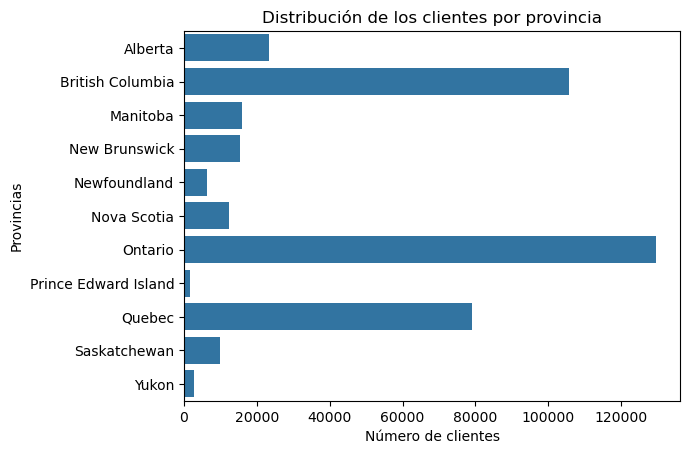

In [ ]:
#Agrupamos los datos por provincia, realizando un conteo de los clientes que hay en cada una de ellas
df_province = df.groupby("Province")["Loyalty Number"].count().reset_index()

sp.sns.barplot(x = "Loyalty Number", y="Province", data=df_province, errorbar=None);
sp.plt.xlabel("Número de clientes")
sp.plt.ylabel("Provincias")
sp.plt.title('Distribución de los clientes por provincia');

Hay tres provincias que destacan sobre las demás: Ontario, British Columbia y Quebec, en ese orden.

---

4. ¿Cómo se compara el salario promedio entre los diferentes niveles educativos de los clientes?

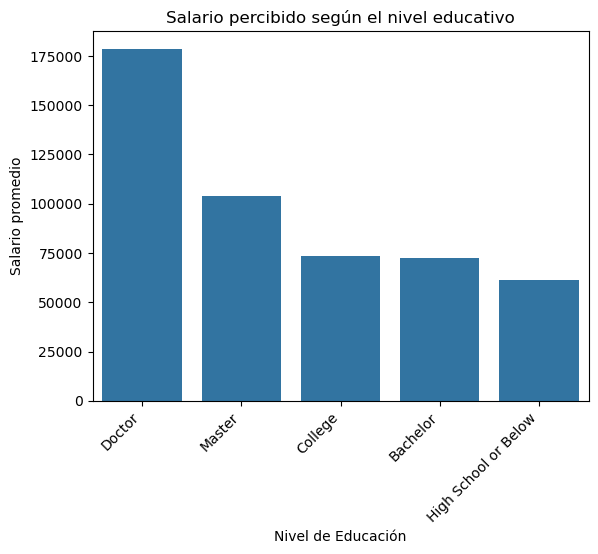

In [18]:
#Calculamos la media salarial por cada nivel educativo y ordenamos de manera descendente
df_educ = (df.groupby("Education")["Salary"].mean().reset_index()).sort_values(by='Salary', ascending=False)

sp.sns.barplot(x = "Education", y="Salary", data=df_educ, errorbar=None);
sp.plt.xlabel("Nivel de Educación")
sp.plt.ylabel("Salario promedio")
sp.plt.xticks(rotation=45, ha='right')  # 45 grados y alineadas a la derecha
sp.plt.title('Salario percibido según el nivel educativo');

A mayor nivel educativo, mayor salario perciben los clientes.

---

5. ¿Cuál es la proporción de clientes con diferentes tipos de tarjetas de fidelidad?

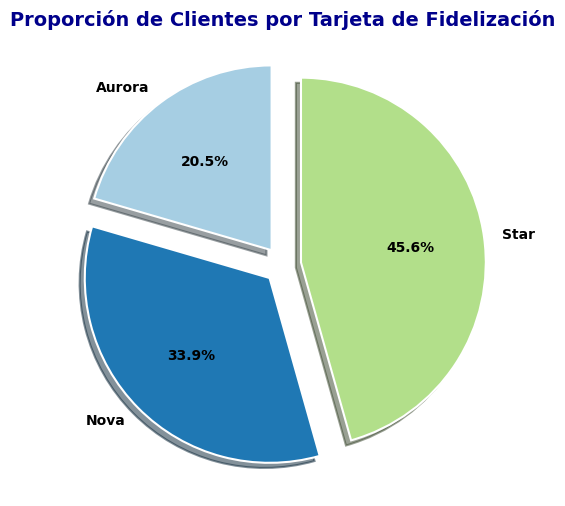

In [19]:
#Realizamos un conteo de los clientes por cada tarjeta de fidelización existente
df_cards = df.groupby("Loyalty Card")["Loyalty Number"].count().reset_index()

# Separa todas las porciones entre sí
explode = [0.1] * len(df_cards)  

sp.plt.figure(figsize=(8, 6))  

# Gráfico de porciones con colores personalizados, bordes y sombra
sp.plt.pie(
    df_cards["Loyalty Number"],  
    labels=df_cards["Loyalty Card"],
    autopct='%1.1f%%',  # Porcentaje con un decimal
    startangle=90,  # Ángulo inicial
    textprops={'fontsize': 10, 'color': 'black', 'fontweight': 'bold'}, 
    colors=sp.plt.cm.Paired.colors,  # Colores más vibrantes
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5},  # Borde blanco y más grueso para las porciones
    shadow=True,  # Añade sombra
    explode=explode,  # Separa todas las porciones
)

# Título con mejor formato
sp.plt.title('Proporción de Clientes por Tarjeta de Fidelización', fontsize=14, fontweight='bold', color='darkblue')

# Añadir un pequeño borde alrededor del gráfico
sp.plt.gca().set_facecolor('whitesmoke')

# Mostrar el gráfico
sp.plt.show()

La proporción de clientes según los distintos programas de fidelización es inversamente proporcional a los beneficios que los programas ofrecen, esto es:

Suponemos que 'Aurora' es el programa de fidelización que mayor beneficios ofrece, es sin embargo el que cuenta con menos clientes.

En contraposición, el programa 'Star' es el que posee mayor número de clientes, pero el que menos beneficios proporciona a estos.

---

6. ¿Cómo se distribuyen los clientes según su estado civil y género?

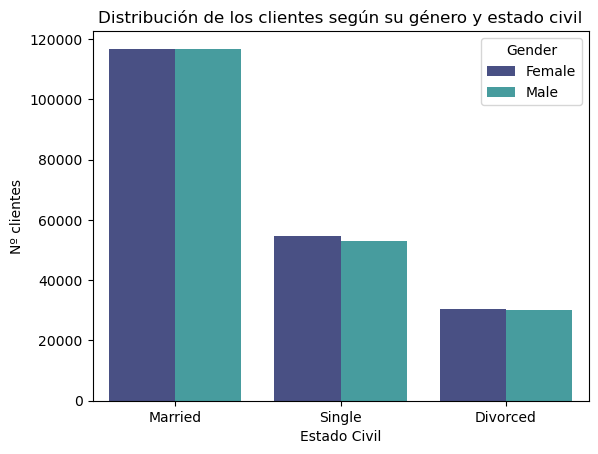

In [20]:
sp.sns.countplot(x = "Marital Status", 
              data = df, 
              palette = "mako", 
              hue = "Gender")

# cambiamos el nombre de los ejes usando los métodos 'plt.ylabel()' y 'plt.xlabel()'
sp.plt.xlabel("Estado Civil")
sp.plt.ylabel("Nº clientes")
sp.plt.title('Distribución de los clientes según su género y estado civil'); 

Podemos afirmar que la diferencia entre hombres y mujeres según su estado civil es prácticamente insignificativa. Por otro lado, destaca un gran número de personas casadas frente a las solteras y divorciadas.

---

### A/B Testing

¿Existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos?

In [21]:
#Filtramos el df por las dos columnas que nos interesa
df_education = df[['Education', 'Flights Booked']]

#Agrupamos por la columna 'Education' y calculamos las estadísticas descriptivas básicas para la columna 'Flights Booked'
stadistics = df.groupby('Education')['Flights Booked'].agg(['mean', 'std', 'min', 'max', 'count', 'sum'])

stadistics

,mean,std,min,max,count,sum
Education,,,,,,
Bachelor,4.129368,5.257359,0,39,251400,1038123
College,4.192209,5.287492,0,38,101712,426398
Doctor,4.202770,5.305066,0,32,17616,74036
High School or Below,4.208919,5.296142,0,31,18768,78993
Master,4.233432,5.266140,0,33,12192,51614


Hacemos dos grupos para realizar el A/B Testing:

Grupo de Control -> Grupo A (Educación Básica/Media):

- High School or Below
- College

Grupo de Prueba -> Grupo B (Educación Superior/Avanzada):

- Bachelor
- Master
- Doctor

Formulamos hipótesis:

- Hipótesis nula (H₀): No hay diferencia en las distribuciones de los dos grupos.
- Hipótesis alternativa (H₁): Hay una diferencia significativa en las distribuciones.

In [22]:
#Añadimos una columna a nuestro df filtrado que especifica a qué grupo pertenece cada valor de la columna 'Education'
df_education['Grupo'] = df_education['Education'].apply(lambda x: 'A' if x in ['High School or Below', 'College'] else 'B')

#Comprobamos la columna 'Grupo'
df_education.head()

,Education,Flights Booked,Grupo
0,Bachelor,3,B
1,Bachelor,2,B
2,Bachelor,14,B
3,Bachelor,4,B
4,Bachelor,0,B


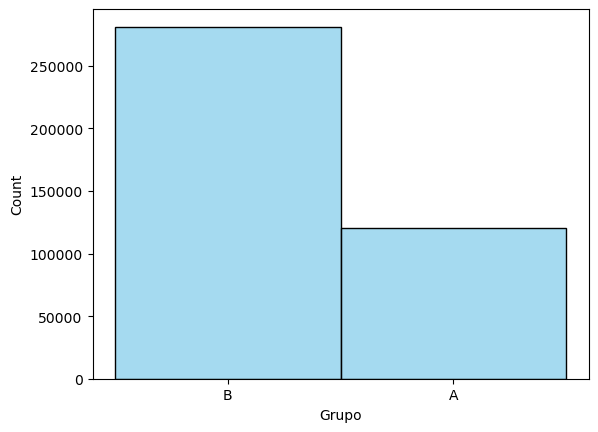

In [23]:
#Vemos la distribución del df con un histplot

sp.sns.histplot(x = "Grupo", data = df_education, color = "skyblue");

In [24]:
#Probamos a hacer una tabla de contingencia
sp.pd.crosstab(df_education['Grupo'], df_education['Flights Booked'], normalize=True) * 100

Flights Booked,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
Grupo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A,14.484625,0.923602,1.036625,1.327647,0.931818,1.132222,1.021191,1.081187,1.062018,1.060774,0.998536,1.190974,0.782448,0.792655,0.53325,0.505616,0.337078,0.303718,0.227789,0.108791,0.097339,0.036845,0.003485,0.001743,0.001494,0.002241,0.001743,0.001992,0.000000,0.000747,0.000498,0.000747,0.000000,0.000498,0.000996,0.000000,0.000249,0.000000,0.000249,0.000000
B,34.104579,2.197726,2.317719,3.157426,2.229342,2.586834,2.400868,2.512896,2.484764,2.438958,2.309504,2.686911,1.790942,1.886290,1.22035,1.132969,0.753570,0.671666,0.511591,0.272351,0.199160,0.102069,0.006224,0.005228,0.004979,0.002987,0.003485,0.002987,0.002489,0.001494,0.000747,0.001494,0.001245,0.000249,0.001992,0.000747,0.000996,0.000249,0.000249,0.000249


Esta tabla de contingencia carece de sentido, por tanto, descartamos Chi Cuadrado como prueba de A/B.

Continuamos comprobando si los datos siguen una distribución normal o no:

In [25]:
metricas = ['Flights Booked']

for metrica in metricas:
    sp.normalidad(df_education ,metrica)

Para la columna Flights Booked los datos no siguen una distribución normal.


Como los datos no siguen una distribución normal, realizamos el test Mann Whitney:

In [26]:
col = ['Flights Booked']

## llamamos a la función
sp.test_mann_whitney(df_education, col, 'A', 'B', 'Grupo')

Para la métrica Flights Booked, las medianas poseen una diferencia significativa.


Por tanto, según el histplot realizado anteriormente, podemos afirmar que se cumple nuestra Hipótesis alternativa (H₁): 

Sí existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos, siendo el Grupo B (Bachelor, Master y Doctor) el que más viajes realiza.